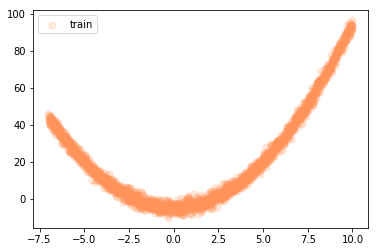

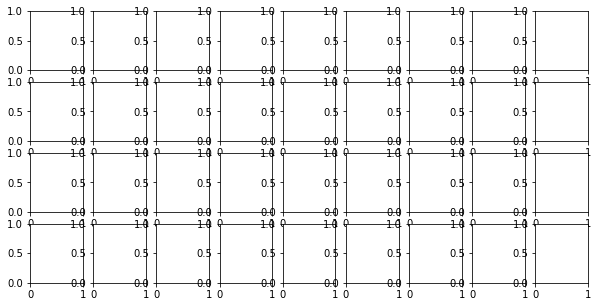

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11


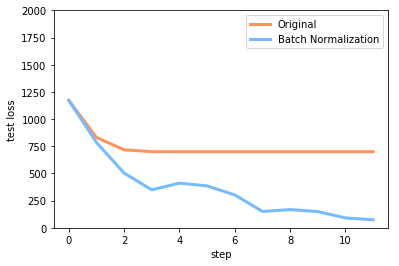

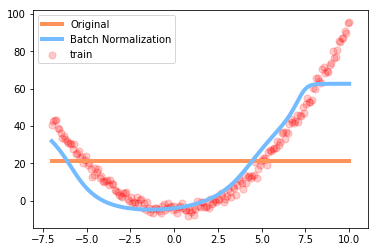

In [2]:
# Jairo Andres Saavedra Alfonso
# 01 de Febrero de 2019
# Universidad de Los Andes
# Phycis 
######################__________________Report 01__________________######################

"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
torch: 0.4
matplotlib
numpy
"""
import torch
from torch import nn
from torch.nn import init
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np

# torch.manual_seed(1)    # reproducible
# np.random.seed(1)

# Hyper parameters
N_SAMPLES = 2000
BATCH_SIZE = 64
EPOCH = 12
LR = 0.03
N_HIDDEN = 8
ACTIVATION = torch.tanh
B_INIT = -0.2   # use a bad bias constant initializer

# training data
x = np.linspace(-7, 10, N_SAMPLES)[:, np.newaxis]
noise = np.random.normal(0, 2, x.shape)
y = np.square(x) - 5 + noise

# test data
test_x = np.linspace(-7, 10, 200)[:, np.newaxis]
noise = np.random.normal(0, 2, test_x.shape)
test_y = np.square(test_x) - 5 + noise

train_x, train_y = torch.from_numpy(x).float(), torch.from_numpy(y).float()
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).float()

train_dataset = Data.TensorDataset(train_x, train_y)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,)

# show data
plt.scatter(train_x.numpy(), train_y.numpy(), c='#FF9359', s=50, alpha=0.2, label='train')
plt.legend(loc='upper left')


class Net(nn.Module):
    def __init__(self, batch_normalization=False):
        super(Net, self).__init__()
        self.do_bn = batch_normalization
        self.fcs = []
        self.bns = []
        self.bn_input = nn.BatchNorm1d(1, momentum=0.5)   # for input data

        for i in range(N_HIDDEN):               # build hidden layers and BN layers
            input_size = 1 if i == 0 else 10
            fc = nn.Linear(input_size, 10)
            setattr(self, 'fc%i' % i, fc)       # IMPORTANT set layer to the Module
            self._set_init(fc)                  # parameters initialization
            self.fcs.append(fc)
            if self.do_bn:
                bn = nn.BatchNorm1d(10, momentum=0.5)
                setattr(self, 'bn%i' % i, bn)   # IMPORTANT set layer to the Module
                self.bns.append(bn)

        self.predict = nn.Linear(10, 1)         # output layer
        self._set_init(self.predict)            # parameters initialization

    def _set_init(self, layer):
        init.normal_(layer.weight, mean=0., std=.1)
        init.constant_(layer.bias, B_INIT)

    def forward(self, x):
        pre_activation = [x]
        if self.do_bn: x = self.bn_input(x)     # input batch normalization
        layer_input = [x]
        for i in range(N_HIDDEN):
            x = self.fcs[i](x)
            pre_activation.append(x)
            if self.do_bn: x = self.bns[i](x)   # batch normalization
            x = ACTIVATION(x)
            layer_input.append(x)
        out = self.predict(x)
        return out, layer_input, pre_activation

nets = [Net(batch_normalization=False), Net(batch_normalization=True)]

# print(*nets)    # print net architecture

opts = [torch.optim.Adam(net.parameters(), lr=LR) for net in nets]

loss_func = torch.nn.MSELoss()


def plot_histogram(l_in, l_in_bn, pre_ac, pre_ac_bn):
    for i, (ax_pa, ax_pa_bn, ax, ax_bn) in enumerate(zip(axs[0, :], axs[1, :], axs[2, :], axs[3, :])):
        [a.clear() for a in [ax_pa, ax_pa_bn, ax, ax_bn]]
        if i == 0:
            p_range = (-7, 10);the_range = (-7, 10)
        else:
            p_range = (-4, 4);the_range = (-1, 1)
        ax_pa.set_title('L' + str(i))
        ax_pa.hist(pre_ac[i].data.numpy().ravel(), bins=10, range=p_range, color='#FF9359', alpha=0.5);ax_pa_bn.hist(pre_ac_bn[i].data.numpy().ravel(), bins=10, range=p_range, color='#74BCFF', alpha=0.5)
        ax.hist(l_in[i].data.numpy().ravel(), bins=10, range=the_range, color='#FF9359');ax_bn.hist(l_in_bn[i].data.numpy().ravel(), bins=10, range=the_range, color='#74BCFF')
        for a in [ax_pa, ax, ax_pa_bn, ax_bn]: a.set_yticks(());a.set_xticks(())
        ax_pa_bn.set_xticks(p_range);ax_bn.set_xticks(the_range)
        axs[0, 0].set_ylabel('PreAct');axs[1, 0].set_ylabel('BN PreAct');axs[2, 0].set_ylabel('Act');axs[3, 0].set_ylabel('BN Act')
    plt.pause(0.01)


if __name__ == "__main__":
    f, axs = plt.subplots(4, N_HIDDEN + 1, figsize=(10, 5))
    plt.ion()  # something about plotting
    plt.show()

    # training
    losses = [[], []]  # recode loss for two networks

    for epoch in range(EPOCH):
        print('Epoch: ', epoch)
        layer_inputs, pre_acts = [], []
        for net, l in zip(nets, losses):
            net.eval()              # set eval mode to fix moving_mean and moving_var
            pred, layer_input, pre_act = net(test_x)
            l.append(loss_func(pred, test_y).data.item())
            layer_inputs.append(layer_input)
            pre_acts.append(pre_act)
            net.train()             # free moving_mean and moving_var
        plot_histogram(*layer_inputs, *pre_acts)     # plot histogram

        for step, (b_x, b_y) in enumerate(train_loader):
            for net, opt in zip(nets, opts):     # train for each network
                pred, _, _ = net(b_x)
                loss = loss_func(pred, b_y)
                opt.zero_grad()
                loss.backward()
                opt.step()    # it will also learns the parameters in Batch Normalization

    plt.ioff()

    # plot training loss
    plt.figure(2)
    plt.plot(losses[0], c='#FF9359', lw=3, label='Original')
    plt.plot(losses[1], c='#74BCFF', lw=3, label='Batch Normalization')
    plt.xlabel('step');plt.ylabel('test loss');plt.ylim((0, 2000));plt.legend(loc='best')

    # evaluation
    # set net to eval mode to freeze the parameters in batch normalization layers
    [net.eval() for net in nets]    # set eval mode to fix moving_mean and moving_var
    preds = [net(test_x)[0] for net in nets]
    plt.figure(3)
    plt.plot(test_x.data.numpy(), preds[0].data.numpy(), c='#FF9359', lw=4, label='Original')
    plt.plot(test_x.data.numpy(), preds[1].data.numpy(), c='#74BCFF', lw=4, label='Batch Normalization')
    plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='r', s=50, alpha=0.2, label='train')
    plt.legend(loc='best')
    plt.show()

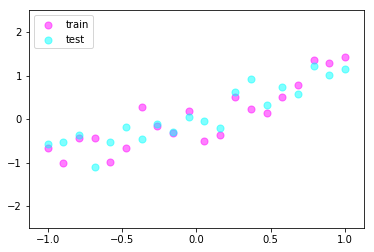

Sequential(
  (0): Linear(in_features=1, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=1, bias=True)
)
Sequential(
  (0): Linear(in_features=1, out_features=300, bias=True)
  (1): Dropout(p=0.5)
  (2): ReLU()
  (3): Linear(in_features=300, out_features=300, bias=True)
  (4): Dropout(p=0.5)
  (5): ReLU()
  (6): Linear(in_features=300, out_features=1, bias=True)
)


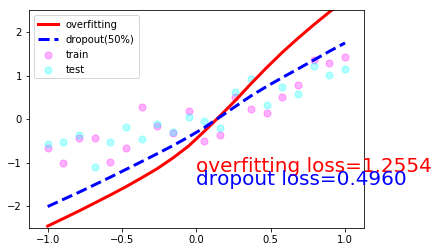

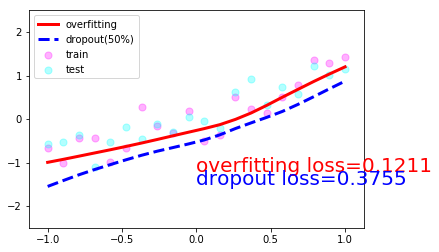

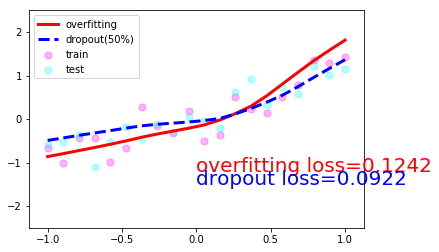

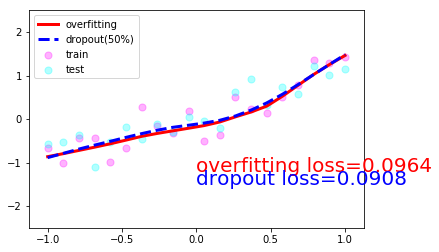

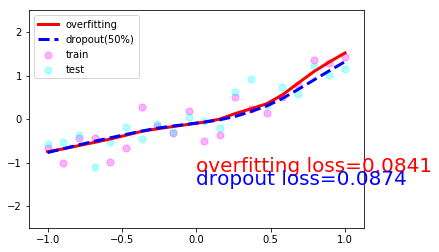

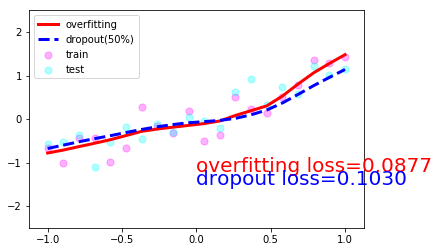

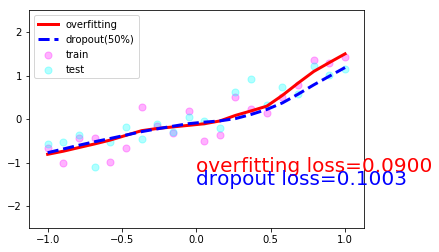

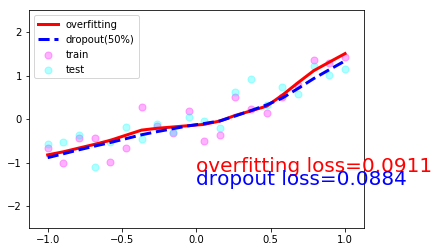

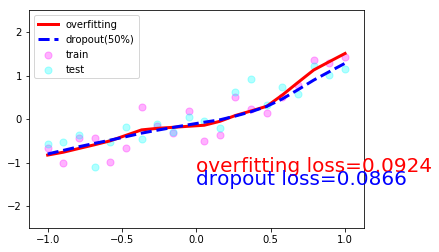

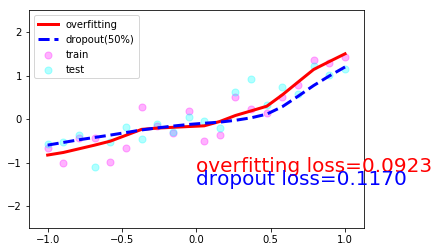

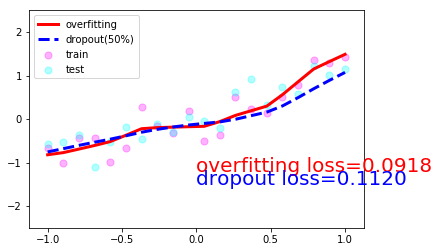

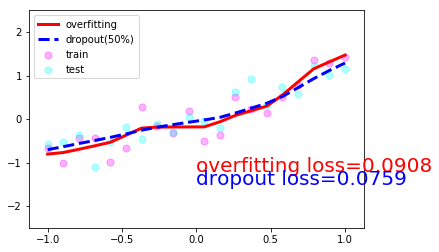

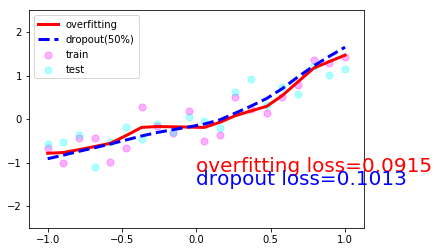

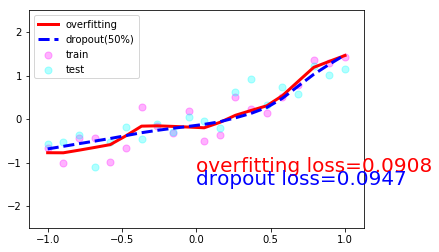

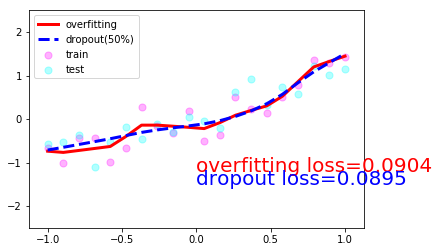

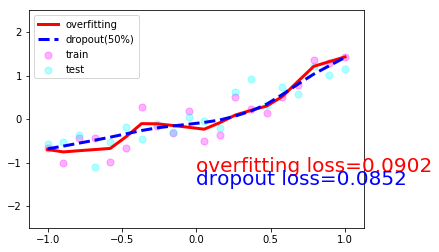

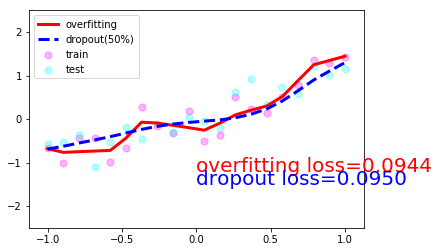

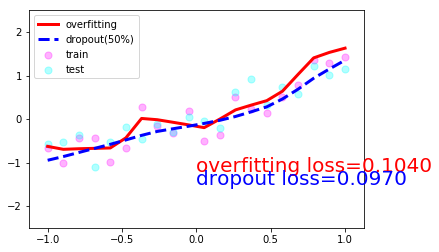

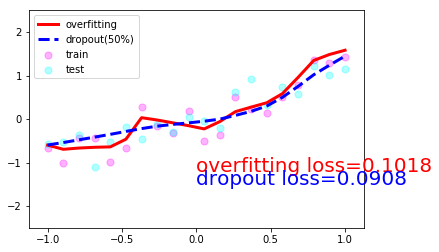

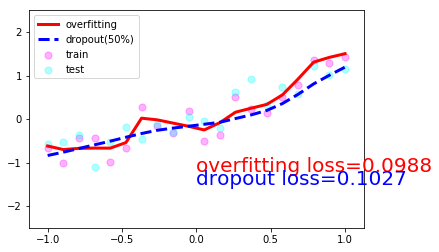

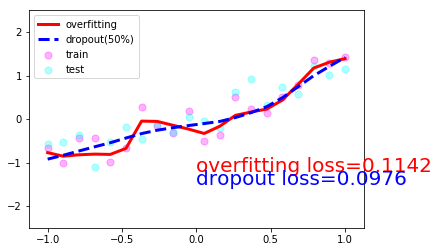

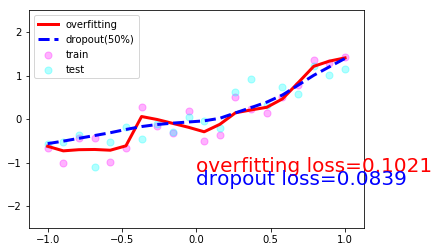

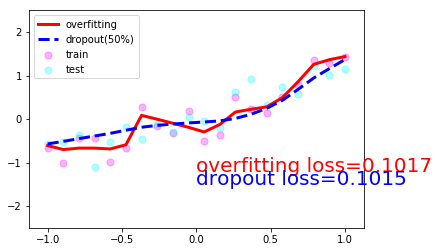

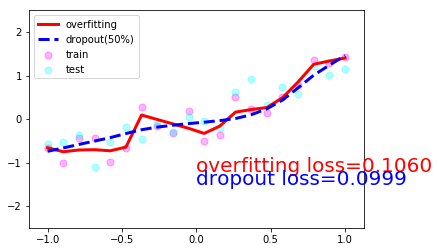

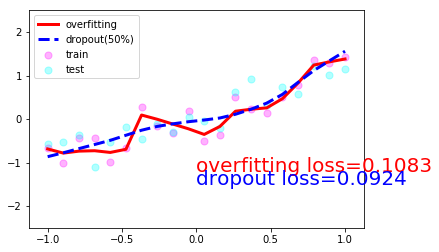

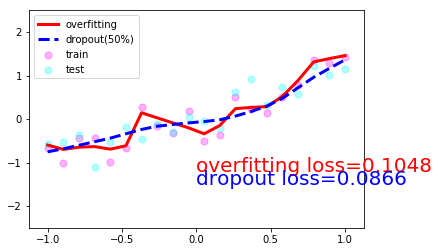

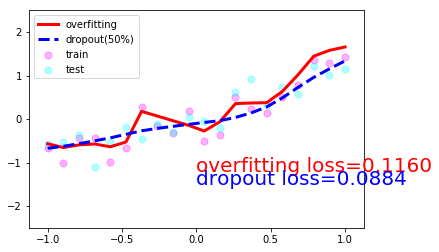

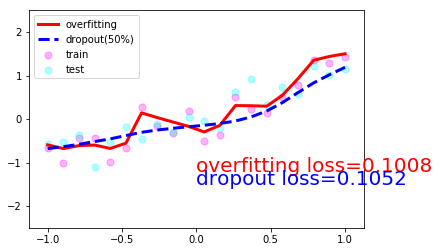

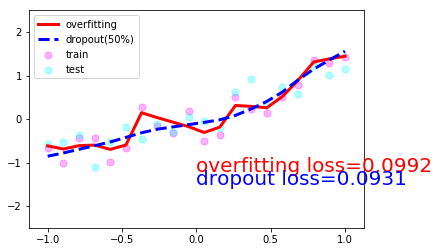

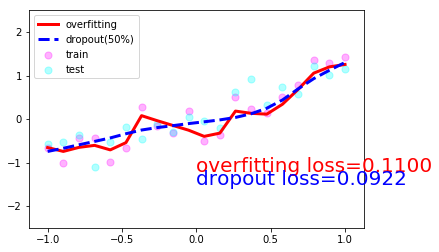

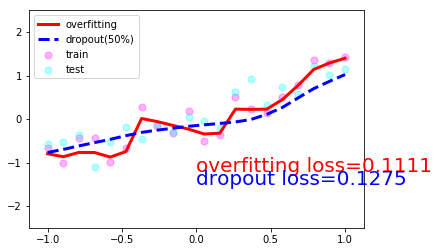

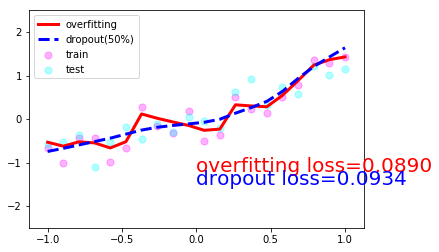

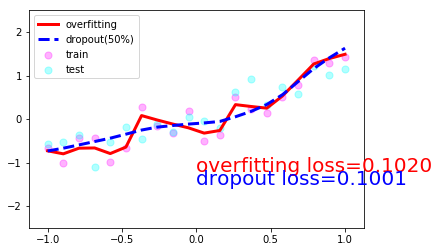

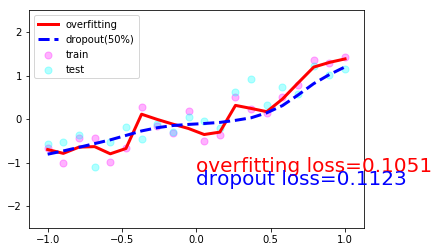

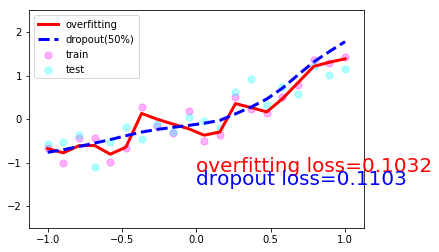

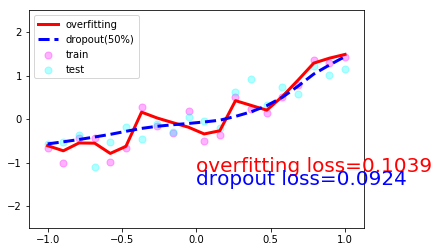

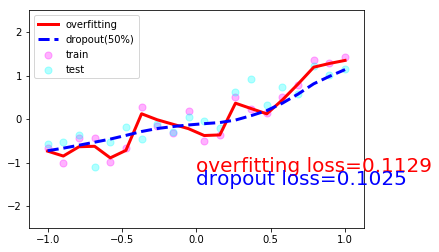

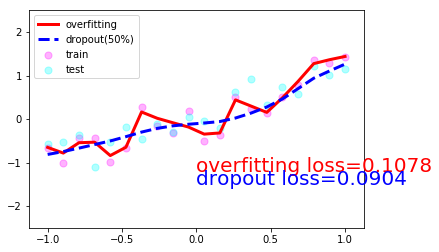

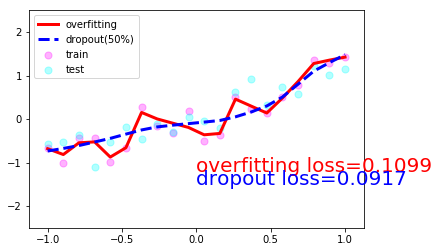

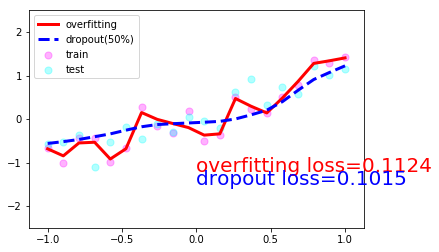

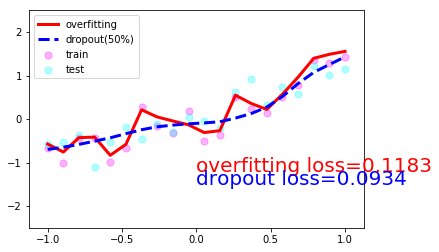

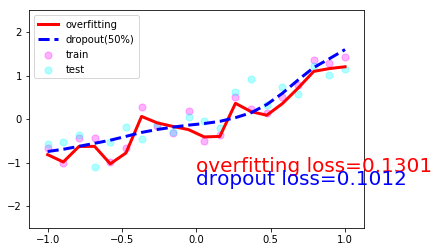

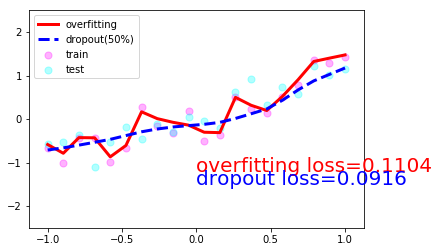

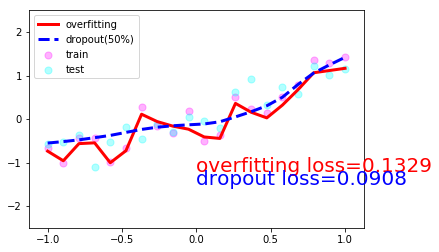

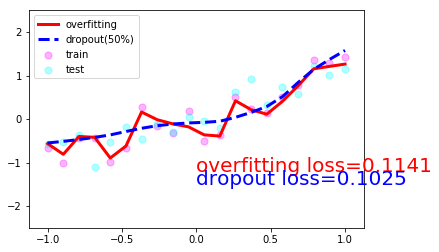

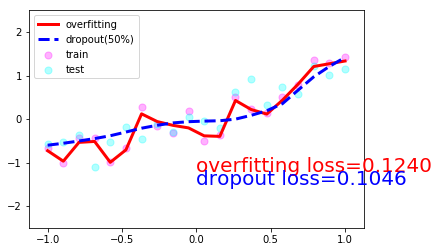

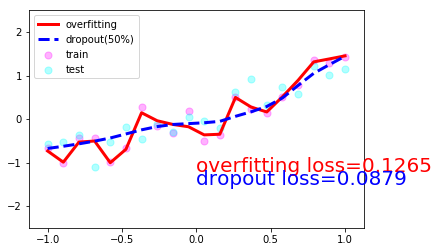

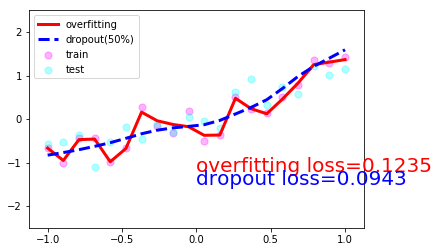

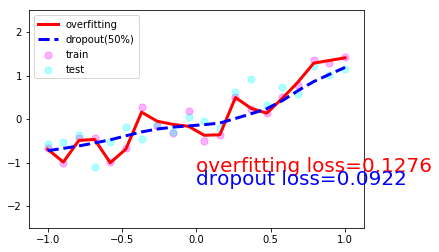

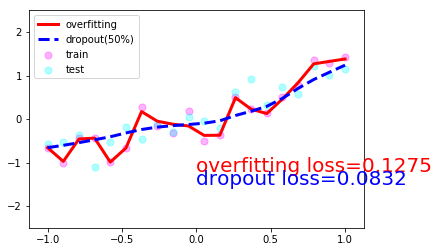

In [3]:
"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
torch: 0.4
matplotlib
"""
import torch
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

N_SAMPLES = 20
N_HIDDEN = 300

# training data
x = torch.unsqueeze(torch.linspace(-1, 1, N_SAMPLES), 1)
y = x + 0.3*torch.normal(torch.zeros(N_SAMPLES, 1), torch.ones(N_SAMPLES, 1))

# test data
test_x = torch.unsqueeze(torch.linspace(-1, 1, N_SAMPLES), 1)
test_y = test_x + 0.3*torch.normal(torch.zeros(N_SAMPLES, 1), torch.ones(N_SAMPLES, 1))

# show data
plt.scatter(x.data.numpy(), y.data.numpy(), c='magenta', s=50, alpha=0.5, label='train')
plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='cyan', s=50, alpha=0.5, label='test')
plt.legend(loc='upper left')
plt.ylim((-2.5, 2.5))
plt.show()

net_overfitting = torch.nn.Sequential(
    torch.nn.Linear(1, N_HIDDEN),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, 1),
)

net_dropped = torch.nn.Sequential(
    torch.nn.Linear(1, N_HIDDEN),
    torch.nn.Dropout(0.5),  # drop 50% of the neuron
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.Dropout(0.5),  # drop 50% of the neuron
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, 1),
)

print(net_overfitting)  # net architecture
print(net_dropped)

optimizer_ofit = torch.optim.Adam(net_overfitting.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(net_dropped.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

plt.ion()   # something about plotting

for t in range(500):
    pred_ofit = net_overfitting(x)
    pred_drop = net_dropped(x)
    loss_ofit = loss_func(pred_ofit, y)
    loss_drop = loss_func(pred_drop, y)

    optimizer_ofit.zero_grad()
    optimizer_drop.zero_grad()
    loss_ofit.backward()
    loss_drop.backward()
    optimizer_ofit.step()
    optimizer_drop.step()

    if t % 10 == 0:
        # change to eval mode in order to fix drop out effect
        net_overfitting.eval()
        net_dropped.eval()  # parameters for dropout differ from train mode

        # plotting
        plt.cla()
        test_pred_ofit = net_overfitting(test_x)
        test_pred_drop = net_dropped(test_x)
        plt.scatter(x.data.numpy(), y.data.numpy(), c='magenta', s=50, alpha=0.3, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='cyan', s=50, alpha=0.3, label='test')
        plt.plot(test_x.data.numpy(), test_pred_ofit.data.numpy(), 'r-', lw=3, label='overfitting')
        plt.plot(test_x.data.numpy(), test_pred_drop.data.numpy(), 'b--', lw=3, label='dropout(50%)')
        plt.text(0, -1.2, 'overfitting loss=%.4f' % loss_func(test_pred_ofit, test_y).data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.text(0, -1.5, 'dropout loss=%.4f' % loss_func(test_pred_drop, test_y).data.numpy(), fontdict={'size': 20, 'color': 'blue'})
        plt.legend(loc='upper left'); plt.ylim((-2.5, 2.5));plt.pause(0.1)

        # change back to train mode
        net_overfitting.train()
        net_dropped.train()

plt.ioff()
plt.show()

In [3]:
#Packages
from astropy.io import fits
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from astropy.table import Table

!jupyter nbconvert --to python Weekly_Reports_CNN.ipynb

[NbConvertApp] Converting notebook Weekly_Reports_CNN.ipynb to python
[NbConvertApp] Writing 25584 bytes to Weekly_Reports_CNN.py


In [3]:
# Reading data from truth_DR12Q.fits. This file have the database sample of spectra with human-expert classifitacion

hdul = fits.open('truth_DR12Q.fits') # Open file
info=hdul.info() # File info
columns=hdul[1].columns # File Columns 
print(info,'/n',columns)
data=hdul[1].data # Database of spectra with human-expert classifications 

Filename: truth_DR12Q.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     27   546856R x 9C   [J, D, J, J, J, J, J, D, D]   
None /n ColDefs(
    name = 'THING_ID'; format = 'J'
    name = 'Z_VI'; format = 'D'
    name = 'PLATE'; format = 'J'
    name = 'MJD'; format = 'J'
    name = 'FIBERID'; format = 'J'
    name = 'CLASS_PERSON'; format = 'J'
    name = 'Z_CONF_PERSON'; format = 'J'
    name = 'BAL_FLAG_VI'; format = 'D'
    name = 'BI_CIV'; format = 'D'
)


Filename: data_dr12.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (886, 639464)   float64   
  1                1 BinTableHDU     16   639464R x 4C   [J, J, J, J]   
[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f98842748>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f7f98842fd0>] /n ColDefs(
    name = 'TARGETID'; format = 'J'
    name = 'PLATE'; format = 'J'
    name = 'MJD'; format = 'J'
    name = 'FIBERID'; format = 'J'
)
[ 87897905  96906927  96907939 ... 505037917 506611870 510289698]
[357405338 353907506  33180814 ... 352121795 401440280 401440241]
(536684,)


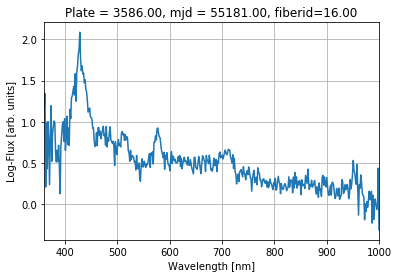

In [4]:
# Reading data from data_dr12.fits. This file had the spectra from data dr12. 
hdul_2 = fits.open('data_dr12.fits') # Open file
info=hdul_2.info() # File info 
columns=hdul_2[1].columns # File Columns 
print(hdul,'/n',columns)
data2=hdul_2[1].data # Database of spectra
spectra=hdul_2[0].data # Spectrum of each object 


# The Spectra in this database have three main parameters: Plate ID, The modified julian day and fiber ID of the observation.
# Let's take a look of the first spectrum.
x=np.linspace(360,1000,443) # I cut the sample to 443 pixels in spaced log-wavelength.  
#x=np.linspace(0,886,886)
zero_spectrum=spectra[12030] #First spectrum
zero_spectrum=zero_spectrum[:443]

PLATE=data2['PLATE'] # Spectra's Plate ID
MJD=data2['MJD'] # Spectra's the modified juliam day
FIBERID=data2['FIBERID'] # Spectra's fiber ID

zero_plate=PLATE[0] # zero spectrum Plate ID
zero_mjd=MJD[0] # zero spectrum MJD
zero_fiberid=FIBERID[0] # zero spectrum Fiber ID
param = 'Plate = {:.2f}, mjd = {:.2f}, fiberid={:.2f}'.format(zero_plate, zero_mjd, zero_fiberid)
plt.plot(x,np.log(zero_spectrum))
plt.xlabel('Wavelength [nm]')
plt.ylabel('Log-Flux [arb. units]')
plt.title(param)
plt.xlim([360,1000])
plt.savefig('spectrum.png')
plt.grid()

# I noticed that each object and spectrum don't have the same label. So it's imposible to make some ID correlations.  
print(data2['TARGETID'])
print(data['THING_ID'])
da=np.intersect1d(data2['TARGETID'],data['THING_ID'])
print(da.shape)

# So, in orden to make a correlation betwen identified object and spectrum we need to use all three parameters (Plate ID, MJD, FiberID)

In [5]:
print(data2.shape)

(639464,)


In [6]:
######################__________________Report 02__________________######################

## This week I pretend to find some correaltions betwen objects with human-expert classification and spretum from DR12

# Subset of PLATE parameters of both data
data_PLATE_1=data['PLATE']
data_PLATE_2=data2['PLATE']

# Subset of MJD parameters of both data
data_MJD_1=data['MJD']
data_MJD_2=data2['MJD']

# Subset of FIBERID parameters of both data
data_FIBERID_1=data['FIBERID']
data_FIBERID_2=data2['FIBERID']

# Subset of FIBERID parameters of both data
data_ID_1=data['THING_ID']
data_ID_2=data2['TARGETID']

# I make here an intersecting set for all three parameters (PLATE, MJD, FIBERID) in both data.
data_PLATE_CO=np.intersect1d(data_PLATE_1,data_PLATE_2)
data_MJD_CO=np.intersect1d(data_MJD_1,data_MJD_2)
data_FIBERID_CO=np.intersect1d(data_FIBERID_1,data_FIBERID_2)
data_ID_CO=np.intersect1d(data_ID_1,data_ID_2)

# As we can see, in both database, there is a correlation betwen the number of Plates, the modified julian day and the Fiber ID. 
print('Number of Plates use in both datasets:',data_PLATE_CO.shape)
print('Number of MJD use in both datasets:',data_MJD_CO.shape)
print('Number of FIBERID use in both datasets:',data_FIBERID_CO.shape)
print('Number of FIBERID use in both datasets:',data_ID_CO.shape)
#print(data_PLATE_1.dtype)

Number of Plates use in both datasets: (2401,)
Number of MJD use in both datasets: (681,)
Number of FIBERID use in both datasets: (1000,)
Number of FIBERID use in both datasets: (536684,)


In [8]:
# I create two DataFrame for Superset_DR12Q and data_dr12 with only three parameters
data1={'PLATE':data_PLATE_1,'MJD':data_MJD_1,'FIBERID':data_FIBERID_1,'ID':data_ID_1}
data1=pd.DataFrame(data=data1)

data2={'PLATE':data_PLATE_2,'MJD':data_MJD_2,'FIBERID':data_FIBERID_2,'ID':data_ID_2}
data2=pd.DataFrame(data=data2)

# I convert all objects in both set to string chain in orden to combine them as one new ID.
data1['PLATE']=data1['PLATE'].astype(str)
data1['MJD']=data1['MJD'].astype(str)
data1['FIBERID']=data1['FIBERID'].astype(str)
data1['PM'] = data1['MJD'].str.cat(data1['FIBERID'],sep="-")
data1['NEWID'] = data1['PLATE'].str.cat(data1['PM'],sep="-")
data_1=data1.drop(columns=['PLATE','MJD','FIBERID','ID','PM']).values


# New set of database 2 with new ID's 
print(data_1.shape)


data2['PLATE']=data2['PLATE'].astype(str)
data2['MJD']=data2['MJD'].astype(str)
data2['FIBERID']=data2['FIBERID'].astype(str)
data2['PM'] = data2['MJD'].str.cat(data2['FIBERID'],sep="-")
data2['NEWID'] = data2['PLATE'].str.cat(data2['PM'],sep="-")
data_2=data2.drop(columns=['PLATE','MJD','FIBERID','ID','PM']).values # New set of database 2 with new ID's
print(data_2.shape)

# With the routine of numpy intersect1d, I find the intersections elements in both sets. This elements  
data_CO=np.array(np.intersect1d(data_1,data_2,return_indices=True))

data_CO_objects=data_CO[0] # The unique new ID of each element in both sets
data_CO_ind1=data_CO[1] # Indices of intersected elements from the original data 1 (Superset_DR12Q.fits) 
data_CO_ind2=data_CO[2] # Indices of intersected elements form the original data 2 (data_dr12.fits)
print('I find',len(data_CO_objects),'objects with spectra from DR12')
print(data_CO_ind1,data_CO_ind2)
indi={'ind1':data_CO_ind1,'ind2':data_CO_ind2}
ind=pd.DataFrame(data=indi,index=data_CO_ind1)



(546856, 1)
(639464, 1)


I find 537677 objects with spectra from DR12
[17792 17931 17610 ... 457655 459274 457504] [25 26 29 ... 639461 639462 639463]


In [10]:
# Now that I know which object have a spectrum. I can make a unique database of objects
hdul = fits.open('truth_DR12Q.fits')
#hdul2 = fits.open('data_dr12.fits')
data=hdul[1].data
info=hdul[1].columns

#ti=np.array(data['THING_ID'],dtype=float)
#pl=np.array(data['PLATE'],dtype=float)
#mjd=np.array(data['MJD'],dtype=float)
#fid=np.array(data['FIBERID'],dtype=float)
cp=np.array(data['CLASS_PERSON'],dtype=float)
z=np.array(data['Z_VI'],dtype=float)
zc=np.array(data['Z_CONF_PERSON'],dtype=float)
bal=np.array(data['BAL_FLAG_VI'],dtype=float)
bi=np.array(data['BI_CIV'],dtype=float)

d={'CLASS_PERSON':cp,'Z_VI':z,'Z_CONF_PERSON':zc,'BAL_FLAG_VI':bal,'BI_CIV':bi}
data_0=pd.DataFrame(data=d)#.values #super database
obj=data_0.loc[data_CO_ind1]

print(obj.shape)



(537677, 5)


In [11]:
######################__________________Report 03__________________######################


# Balance of classes 
C_P=obj['CLASS_PERSON'] #Class Person column 
STAR=C_P[C_P==1] # objects classified as stars
GALAXY=C_P[C_P==4] # objects classified as galaxies 
QSO=C_P[C_P==3] # objects classified as QSO (Quasars)
QSO_BAL=C_P[C_P==30] # objects classified as QSO BAL (Quasars with Broad Absortions Lines)
N_C=C_P[C_P!=30]   
N_C=N_C[N_C!=3]
N_C=N_C[N_C!=1]
N_C=N_C[N_C!=4] # objects wrong classified
print('Stars:',STAR.shape)
print('Galaxies:',GALAXY.shape)
print('QSO:',QSO.shape)
print('QSO BAL:',QSO_BAL.shape)
print('No class:',N_C.shape)

Stars: (207905,)
Galaxies: (20699,)
QSO: (270534,)
QSO BAL: (29652,)
No class: (8887,)


In [12]:
# Preprocessing. I remove non-classified objects also objects with negative redshift.  
stars=obj.loc[obj['CLASS_PERSON']==1]
galaxies=obj.loc[obj['CLASS_PERSON']==4]
qsos=obj.loc[obj['CLASS_PERSON']==3]
qsos_bal=obj.loc[obj['CLASS_PERSON']==30]

frames=[stars,galaxies,qsos,qsos_bal]
new_obj=pd.concat(frames)#, keys=['stars', 'galaxies', 'qso','qso_bal'])

#new_obj=new_obj.loc[new_obj['Z_VI']!=0]
obj=new_obj.loc[new_obj['Z_CONF_PERSON']!=0]
#indio=np.array(obj.index)
#for i in range(len(indio)):
#    print(indio[i])
print(obj.shape)

(528790, 5)


In [13]:
# Sample of objects. I chosen 250 object per class. 
stars=obj.loc[obj['CLASS_PERSON']==1]
galaxies=obj.loc[obj['CLASS_PERSON']==4]
qsos=obj.loc[obj['CLASS_PERSON']==3]
qsos_bal=obj.loc[obj['CLASS_PERSON']==30]

N_sample=30000
epoc=10
batch_size=int(N_sample/epoc)


sample_star=stars.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)
sample_galaxy=galaxies.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=6)
sample_qso=qsos.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=7)
sample_qso_bal=qsos_bal.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=2)

sample_objects=pd.concat([sample_star,sample_galaxy,sample_qso,sample_qso_bal])

ind_star=np.array(sample_star.index)
ind_galaxy=np.array(sample_galaxy.index)
ind_qso=np.array(sample_qso.index)
ind_qso_bal=np.array(sample_qso_bal.index)

indi=np.concatenate((ind_star, ind_galaxy,ind_qso,ind_qso_bal), axis=None)
indi1=ind.loc[indi].values
#print(indi)

print(spectra.shape,indi.shape)


(639464, 886) (20000,)


In [14]:
hdul_2 = fits.open('data_dr12.fits') # Open file
data2=hdul_2[1].data # Database of spectra
spectra=hdul_2[0].data # Spectrum of each object 

spectra_=np.zeros((N_sample,443))

j=0
for i in indi:
    k=indi1[j,1]
    #mflux = np.ma.average(spectra[k,:443], weights=spectra[k,443:])
    #ll=(spectra[k,:443]-mflux)**2
    #aveflux=np.ma.average(ll, weights=spectra[k,443:])
    #sflux = np.sqrt(aveflux)
    spectra_[j,:]=np.log10(abs((spectra[k,:443])))#-mflux)/sflux))
    j=j+1    
    
spectra_=pd.DataFrame(spectra_)
X=spectra_.replace(-np.inf,0)


X=X.values

y=sample_objects['CLASS_PERSON']
y=y.replace([1, 4, 3, 30], [0,1,2,3]).values
y=np.array(y,dtype=float)
#y=y.values.reshape(-1,1)
#sample_objects.loc[sample_objects['CLASS_PERSON'] == 1] = "Star"
print(X[0,:].reshape(1,-1).shape,y.shape) 

/home/steingate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


(1, 443) (20000,)


In [15]:

"""
# Reading data from data_dr12.fits. This file had the spectra from data dr12. 
hdul_2 = fits.open('data_dr12.fits') # Open file
info=hdul_2.info() # File info 
columns=hdul_2[1].columns # File Columns 
print(hdul,'/n',columns)
data2=hdul_2[1].data # Database of spectra
spectra=hdul_2[0].data # Spectrum of each object 


# The Spectra in this database have three main parameters: Plate ID, The modified julian day and fiber ID of the observation.
# Let's take a look of the first spectrum.
x=np.linspace(360,1000,443) # I cut the sample to 443 pixels in spaced log-wavelength.  
#x=np.linspace(0,886,886)
#zero_spectrum=spectra[12030] #First spectrum
#zero_spectrum=zero_spectrum[:443]

PLATE=data2['PLATE'] # Spectra's Plate ID
MJD=data2['MJD'] # Spectra's the modified juliam day
FIBERID=data2['FIBERID'] # Spectra's fiber ID

index=[ind_star[0],ind_galaxy[0],ind_qso[10],ind_qso_bal[0]]
print(index)
n=0
for i in index:
    sp=spectra[i]
    plate=PLATE[i]
    mjd=MJD[i]
    fiberid=FIBERID[i] 
    tar=obj.loc[i]
    param = 'Plate = {:.2f}, mjd = {:.2f}, fiberid={:.2f}\n Z={:.2f}'.format(plate, mjd, fiberid,tar[1])
    plt.plot(x,np.log(abs(sp[:443])))
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Log-Flux [arb. units]')
    plt.title(param)
    plt.xlim([360,1000])
    plt.grid()
    sav='spectro{:.2f}.jpg'.format(n)
    plt.savefig(sav)
    n+=1
    plt.show()

    print(tar[1])
    
#buscar aqui los objetos de QuasarNET
"""

"\n# Reading data from data_dr12.fits. This file had the spectra from data dr12. \nhdul_2 = fits.open('data_dr12.fits') # Open file\ninfo=hdul_2.info() # File info \ncolumns=hdul_2[1].columns # File Columns \nprint(hdul,'/n',columns)\ndata2=hdul_2[1].data # Database of spectra\nspectra=hdul_2[0].data # Spectrum of each object \n\n\n# The Spectra in this database have three main parameters: Plate ID, The modified julian day and fiber ID of the observation.\n# Let's take a look of the first spectrum.\nx=np.linspace(360,1000,443) # I cut the sample to 443 pixels in spaced log-wavelength.  \n#x=np.linspace(0,886,886)\n#zero_spectrum=spectra[12030] #First spectrum\n#zero_spectrum=zero_spectrum[:443]\n\nPLATE=data2['PLATE'] # Spectra's Plate ID\nMJD=data2['MJD'] # Spectra's the modified juliam day\nFIBERID=data2['FIBERID'] # Spectra's fiber ID\n\nindex=[ind_star[0],ind_galaxy[0],ind_qso[10],ind_qso_bal[0]]\nprint(index)\nn=0\nfor i in index:\n    sp=spectra[i]\n    plate=PLATE[i]\n    mjd=MJ

In [16]:
print(y)

[0. 0. 0. ... 3. 3. 3.]


In [17]:
######################__________________Report 05__________________######################

# my first Neural Network. SpectraNET :}

import torch 
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.autograd import Variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)



In [18]:
import torch.utils.data

train_data = []
for i in range(y_train.shape[0]):
    xt=X_train[i,:].reshape(1,-1)
    train_data.append([Variable(torch.tensor(xt, dtype=torch.float)), torch.tensor(y_train[i], dtype=torch.long)])
    
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
i1, l1 = next(iter(train_loader))
print(i1.shape,l1.shape)


torch.Size([2000, 1, 443]) torch.Size([2000])


In [19]:
test_data = []
for i in range(y_test.shape[0]):
    xtst=X_test[i,:].reshape(1,-1)
    test_data.append([Variable(torch.tensor(xtst, dtype=torch.float)), torch.tensor(y_test[i], dtype=torch.long)])
    
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)
i1, l1 = next(iter(test_loader))
print(i1.shape,l1.shape)

torch.Size([2000, 1, 443]) torch.Size([2000])


In [20]:
"""
test_data = []
for i in range(y_test.shape[0]):
    xtst=X_test[i,:].reshape(1,-1)
    test_data.append([Variable(torch.tensor(xtst, dtype=torch.float)), torch.tensor(y_test[i], dtype=torch.long)])
    
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)
i1, l1 = next(iter(test_loader))
print(i1.shape,l1.shape)
"""


'\ntest_data = []\nfor i in range(y_test.shape[0]):\n    xtst=X_test[i,:].reshape(1,-1)\n    test_data.append([Variable(torch.tensor(xtst, dtype=torch.float)), torch.tensor(y_test[i], dtype=torch.long)])\n    \ntest_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)\ni1, l1 = next(iter(test_loader))\nprint(i1.shape,l1.shape)\n'

In [20]:
from astropy.io import fits
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import torch 
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.utils.data

def Load_Files(file_1,file_2,N_sample=20000,classification=True):
    hdul = fits.open(file_1) # Open file 1 -- 'truth_DR12Q.fits'
    info=hdul.info() # File info
    columns=hdul[1].columns # File Columns 
    print(info,'/n',columns)
    data=hdul[1].data # Database of spectra with human-expert classifications 

    # Reading data from data_dr12.fits. This file had the spectra from data dr12. 
    hdul_2 = fits.open(file_2) # Open file 2 -- 'data_dr12.fits'
    info=hdul_2.info() # File info 
    columns=hdul_2[1].columns # File Columns
    print(hdul,'/n',columns)
    data2=hdul_2[1].data # Database of spectra
    spectra=hdul_2[0].data # Spectrum of each object 
    
    # Subset of PLATE parameters of both data
    data_PLATE_1=data['PLATE']
    data_PLATE_2=data2['PLATE']

    # Subset of MJD parameters of both data
    data_MJD_1=data['MJD']
    data_MJD_2=data2['MJD']

    # Subset of FIBERID parameters of both data
    data_FIBERID_1=data['FIBERID']
    data_FIBERID_2=data2['FIBERID']
    data_ID_1=data['THING_ID']
    data_ID_2=data2['TARGETID']
    
    # The column 'CLASS_PERSON' have a class identifier for each spectrum: STARS=1, GALAXY=4, QSO=3 and QSO_BAL=30.
    C_P=data['CLASS_PERSON'] #Class Person column 
    STAR=C_P[C_P==1] # objects classified as stars
    GALAXY=C_P[C_P==4] # objects classified as galaxies 
    QSO=C_P[C_P==3] # objects classified as QSO (Quasars)
    QSO_BAL=C_P[C_P==30] # objects classified as QSO BAL (Quasars with Broad Absortions Lines)
    N_C=C_P[C_P!=30]   
    N_C=N_C[N_C!=3]
    N_C=N_C[N_C!=1]
    N_C=N_C[N_C!=4] # objects wrong classified
    print('Star:',STAR.shape)
    print('Galaxy:',GALAXY.shape)
    print('QSO:',QSO.shape)
    print('QSO BAL:',QSO_BAL.shape)
    print('NN:',N_C.shape)
    
    # I create two DataFrame for Superset_DR12Q and data_dr12 with only three parameters
    data1={'PLATE':data_PLATE_1,'MJD':data_MJD_1,'FIBERID':data_FIBERID_1,'ID':data_ID_1}
    data1=pd.DataFrame(data=data1)

    data2={'PLATE':data_PLATE_2,'MJD':data_MJD_2,'FIBERID':data_FIBERID_2,'ID':data_ID_2}
    data2=pd.DataFrame(data=data2)

    # I convert all objects in both set to string chain in orden to combine them as one new ID.
    data1['PLATE']=data1['PLATE'].astype(str)
    data1['MJD']=data1['MJD'].astype(str)
    data1['FIBERID']=data1['FIBERID'].astype(str)
    data1['PM'] = data1['MJD'].str.cat(data1['FIBERID'],sep="-")
    data1['NEWID'] = data1['PLATE'].str.cat(data1['PM'],sep="-")
    data_1=data1.drop(columns=['PLATE','MJD','FIBERID','ID','PM']).values

    data2['PLATE']=data2['PLATE'].astype(str)
    data2['MJD']=data2['MJD'].astype(str)
    data2['FIBERID']=data2['FIBERID'].astype(str)
    data2['PM'] = data2['MJD'].str.cat(data2['FIBERID'],sep="-")
    data2['NEWID'] = data2['PLATE'].str.cat(data2['PM'],sep="-")
    data_2=data2.drop(columns=['PLATE','MJD','FIBERID','ID','PM']).values # New set of database 2 with new ID's
    print(data_2.shape)

    # With the routine of numpy intersect1d, I find the intersections elements in both sets. This elements  
    data_CO=np.array(np.intersect1d(data_1,data_2,return_indices=True))

    data_CO_objects=data_CO[0] # The unique new ID of each element in both sets
    data_CO_ind1=data_CO[1] # Indices of intersected elements from the original data 1 (Superset_DR12Q.fits) 
    data_CO_ind2=data_CO[2] # Indices of intersected elements form the original data 2 (data_dr12.fits)
    print('I find',len(data_CO_objects),'objects with spectra from DR12')
    print(data_CO_ind1,data_CO_ind2)
    indi={'ind1':data_CO_ind1,'ind2':data_CO_ind2}
    ind=pd.DataFrame(data=indi,index=data_CO_ind1)

    cp=np.array(data['CLASS_PERSON'],dtype=float)
    z=np.array(data['Z_VI'],dtype=float)
    zc=np.array(data['Z_CONF_PERSON'],dtype=float)
    bal=np.array(data['BAL_FLAG_VI'],dtype=float)
    bi=np.array(data['BI_CIV'],dtype=float)

    d={'CLASS_PERSON':cp,'Z_VI':z,'Z_CONF_PERSON':zc,'BAL_FLAG_VI':bal,'BI_CIV':bi}
    data_0=pd.DataFrame(data=d)#.values #super database
    obj=data_0.loc[data_CO_ind1]

    print(obj.shape)
    # Sample of objects. I chosen 2500 object per class. 
    stars=obj.loc[obj['CLASS_PERSON']==1]
    galaxies=obj.loc[obj['CLASS_PERSON']==4]
    qsos=obj.loc[obj['CLASS_PERSON']==3]
    qsos_bal=obj.loc[obj['CLASS_PERSON']==30]

    sample_star=stars.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)
    sample_galaxy=galaxies.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)
    sample_qso=qsos.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)
    sample_qso_bal=qsos_bal.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)

    sample_objects=pd.concat([sample_star,sample_galaxy,sample_qso,sample_qso_bal])

    ind_star=np.array(sample_star.index)
    ind_galaxy=np.array(sample_galaxy.index)
    ind_qso=np.array(sample_qso.index)
    ind_qso_bal=np.array(sample_qso_bal.index)

    indi=np.concatenate((ind_star, ind_galaxy,ind_qso,ind_qso_bal), axis=None)
    indi1=ind.loc[indi].values
    #print(indi)

    spectra_=np.zeros((N_sample,443))
    j=0
    for i in indi:
        k=indi1[j,1]
        spectra_[j,:]=np.log(abs(spectra[k,:443]))
        j=j+1    
    spectra_=pd.DataFrame(spectra_)
    X=spectra_.replace(-np.inf,0)


    X=X.values # Spectra
    
    if(classification!=True):
        y=sample_objects['Z_VI']
        y=np.array(y,dtype=float)
        return X,y
    else:  
        y=sample_objects['CLASS_PERSON']
        y=y.replace([1, 4, 3, 30], [0,1,2,3]).values
        y=np.array(y,dtype=float)
        return X,y

In [24]:
def Loader(X,y,N_sample=20000,epoc=10):
    
    batch_size=int(N_sample/epoc)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
    
    train_data = []
    
    for i in range(y_train.shape[0]):
        xt=X_train[i,:].reshape(1,-1)
        train_data.append([Variable(torch.tensor(xt, dtype=torch.float)), torch.tensor(y_train[i], dtype=torch.long)])
    
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

    test_data = []
    for i in range(y_test.shape[0]):
        xtst=X_test[i,:].reshape(1,-1)
        test_data.append([Variable(torch.tensor(xtst, dtype=torch.float)), torch.tensor(y_test[i], dtype=torch.long)])
    
    test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)
    
    val_data = []
    for i in range(y_val.shape[0]):
        xv=X_val[i,:].reshape(1,-1)
        val_data.append([Variable(torch.tensor(xv, dtype=torch.float)), torch.tensor(y_val[i], dtype=torch.long)])
    
    val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)
    return train_loader,test_loader,val_loader

In [25]:
X,y=Load_Files('truth_DR12Q.fits','data_dr12.fits',N_sample=20000,classification=True)
train_loader,test_loader,val_loader=Loader(X,y,N_sample=20000,epoc=10)

Filename: truth_DR12Q.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     27   546856R x 9C   [J, D, J, J, J, J, J, D, D]   
None /n ColDefs(
    name = 'THING_ID'; format = 'J'
    name = 'Z_VI'; format = 'D'
    name = 'PLATE'; format = 'J'
    name = 'MJD'; format = 'J'
    name = 'FIBERID'; format = 'J'
    name = 'CLASS_PERSON'; format = 'J'
    name = 'Z_CONF_PERSON'; format = 'J'
    name = 'BAL_FLAG_VI'; format = 'D'
    name = 'BI_CIV'; format = 'D'
)
Filename: data_dr12.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (886, 639464)   float64   
  1                1 BinTableHDU     16   639464R x 4C   [J, J, J, J]   
[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f02e16a6fd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f01c2c688d0>] /n ColDefs(
    name = 'TARGETID'; format = 'J'
    name = 'PLATE'; for

/home/steingate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in log


In [26]:
# CNN for classification
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support

learning_rate=0.01
log_interval=10
epoc=10
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 100, 10,stride=2)
        self.conv2 = nn.Conv1d(100, 100, 10,stride=2)
        self.conv3 = nn.Conv1d(100, 100, 10,stride=2)
        self.conv4 = nn.Conv1d(100, 100, 10,stride=2)
        self.pool = nn.MaxPool1d(2, 1)
        self.fc1 = nn.Linear(1800, 16)
        #self.fc1 = nn.Linear(10300, 16)
        self.fc2 = nn.Linear(16, 4)


    def forward(self, x):
        in_size = x.size(0)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(in_size, -1)
        x = F.relu(self.fc1(x))        
        x = self.fc2(x)
        #print(x.shape)
        return F.log_softmax(x)
    
net = Net()
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

def train(epoch):
    #model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader,0):
        data, target = Variable(data), Variable(target)
        #print(data.shape,target.shape)
        #images=data[batch_idx,0]
        #plt.imshow(images)
        #plt.show()
        
        optimizer.zero_grad()
        
        output = net(data)
        #print(output,'target',target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        print(batch_idx,running_loss)
        #if(batch_idx !=0):    # print every 2000 mini-batches
            #print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 1000))
            #running_loss = 0.0
    

print('Finished Training')
        
for i in range(epoc):
    train(i)



Net(
  (conv1): Conv1d(1, 100, kernel_size=(10,), stride=(2,))
  (conv2): Conv1d(100, 100, kernel_size=(10,), stride=(2,))
  (conv3): Conv1d(100, 100, kernel_size=(10,), stride=(2,))
  (conv4): Conv1d(100, 100, kernel_size=(10,), stride=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1800, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=4, bias=True)
)
Finished Training


/home/steingate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0 1.3874688148498535
1 2.767642021179199
2 4.1316609382629395
3 5.484070181846619
4 6.824437141418457
5 8.125621795654297
0 1.2975345849990845
1 2.576548457145691
2 3.844681143760681
3 5.093807578086853
4 6.326760649681091
5 7.5423743724823
0 1.2079722881317139
1 2.3844164609909058
2 3.538949131965637
3 4.6710638999938965
4 5.752697944641113
5 6.81868052482605
0 1.0165553092956543
1 1.992371916770935
2 2.9773935079574585
3 3.9167532324790955
4 4.838084042072296
5 5.794525384902954
0 0.9666631817817688
1 1.851479172706604
2 2.753343105316162
3 3.627561867237091
4 4.475330054759979
5 5.346321165561676
0 0.7998954057693481
1 1.620369791984558
2 2.401349663734436
3 3.1787281036376953
4 3.947839856147766
5 4.667463958263397
0 0.762728214263916
1 1.5111482739448547
2 2.464438557624817
3 3.18178391456604
4 4.0206053256988525
5 4.76045286655426
0 0.7269543409347534
1 1.5012619495391846
2 2.256326198577881
3 2.9773610830307007
4 3.7057759761810303
5 4.410092890262604
0 0.6715760827064514
1 1.41

In [27]:
correct = 0
total = 0
d=[]
d1=[]
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted,predicted.shape)
        d.append(predicted)
        d1.append(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
#d=np.asarray(d)
print(d[0].shape)
print(d1[0].shape)
y_pred=torch.cat((d[0],d[1]),0)
y_test=torch.cat((d1[0],d1[1]),0)
print(y_pred)

/home/steingate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 5000 test images: 78 %
torch.Size([2000])
torch.Size([2000])
tensor([2, 3, 3,  ..., 2, 0, 2])


Confusion matrix, without normalization
[[ 995    0    0    0]
 [   0 1024    0    0]
 [   0    0 1004    0]
 [   0    0    0  977]]
Confusion matrix, without normalization
[[917  62  16   0]
 [188 789  45   2]
 [ 28  77 800  99]
 [  9  33 317 618]]
(array([0.8 , 0.82, 0.68, 0.86]), array([0.92, 0.77, 0.8 , 0.63]), array([0.86, 0.79, 0.73, 0.73]), array([ 995, 1024, 1004,  977]))


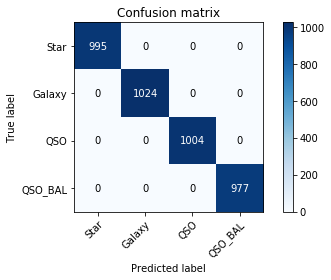

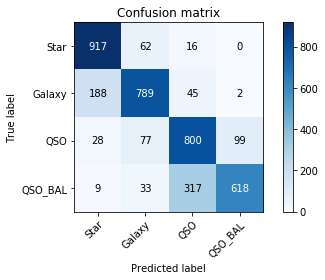

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

class_names=['Star','Galaxy','QSO','QSO_BAL']

def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,title=None,cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.subplots(121)
#y_test=y_test.detach().numpy()
#y_pred=y_pred.detach().numpy()
#print(y_pred)
plot_confusion_matrix(y_test, y_test, classes=class_names, title='Confusion matrix')
plt.savefig('cm_train.png')
#plt.subplots(122)
plot_confusion_matrix(y_test, y_pred, classes=class_names, title='Confusion matrix')
plt.savefig('cm_test.png')

from sklearn.metrics import precision_recall_curve
prf=precision_recall_fscore_support(y_test, y_pred, average=None)#,labels=['Star','Galaxy','QSO','QSO_BAL'])

print(prf)

In [29]:
classes = ('Star', 'Galaxy', 'QSO', 'QSO_BAL')
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(4):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/home/steingate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of  Star : 100 %
Accuracy of Galaxy : 100 %
Accuracy of   QSO : 50 %
Accuracy of QSO_BAL : 50 %
